# Part 1: Data Ingestion


In this notebook we will learn how to **Ingest** different data sources to our **Feature Store**. Specifically, this transactions dataset used to detect transactions fraud.  


We will walk through creation of ingestion pipeline for each datasource with all the needed preprocessing and validation. We will run the pipeline locally within the notebook and then launch a real-time function to **ingest live data** or schedule a cron to run the task when needed.

## Environment Setup

Since our work is done in a this project scope, first define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun
import os

mlrun.set_environment(project='fraud-demo', user_project=True)
# location of the output data files
data_path = os.path.abspath('data/')

## Create Ingestion Pipeline With MLRun
In this section we will ingest the lab measurements data using MLRun and Storey. Storey is the underlying implementation of the feature store which is used by MLRun. It is the engine that allows you to define and execute complex graphs that create the feature engineering pipeline. With storey, you can define source, transformations and targets, many actions are available as part of the Storey library, but you can define additional actions easily. We will see these custom actions in later sections.

For the execution, it is possible to also use Spark. The main difference between Storey and Spark pipelines is that Storey blocks are built for Real-Time workloads while Spark is more Batch oriented.  
We will now do the following:
- Create the `transactions` FeatureSet
- Create the `events` FeatureSet

- Define Preprocessing graph including aggregations
- Ingest the data using the defined pipeline

In [2]:
# Import MLRun's Feature Store
import mlrun.feature_store as fs

# Import MLRun's Data Sources to set the wanted ingestion pipeline
from mlrun.datastore.sources import DataFrameSource
from mlrun.datastore.targets import ParquetTarget, NoSqlTarget

In [3]:
import pandas as pd
data = pd.read_csv('data/data.csv', parse_dates=['timestamp'])
data = data.sample(100000)
data.head()

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
321704,104,4,F,28007,28007,es_wellnessandbeauty,63.48,0,2020-03-02 00:32:41.379426,C886658445,M1946091778,06731466446f4de4b22efc42cd5cc86d
145107,51,2,F,28007,28007,es_transportation,39.08,0,2020-04-04 04:37:48.094624,C15777324,M1823072687,4e9efd737f0545bda0b0ea2730493615
170178,59,3,F,28007,28007,es_transportation,29.68,0,2020-01-01 12:17:14.234501,C1941625566,M348934600,52445dd1a7ff4c998715714cb61281ce
152163,53,3,F,28007,28007,es_transportation,22.16,0,2020-03-28 20:09:43.812029,C251449240,M348934600,d7638b69a15c49788afbb8228ef6e725
37052,14,2,F,28007,28007,es_transportation,0.59,0,2020-10-24 12:27:31.115236,C1960353164,M348934600,967d8f0816e543e1999d40245ded8f32


### Define the Transactions Set

In [4]:
from typing import List, Dict, Union
import pandas as pd
import storey

class DateExtractor(storey.MapClass):
    def __init__(
        self,
        parts: Union[Dict[str, str], List[str]],
        timestamp_col: str = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.timestamp_col = timestamp_col
        self.parts = parts

    def _get_key_name(self, part:str, timestamp_col: str):
        timestamp_col = timestamp_col if timestamp_col else 'timestamp'
        return f'{timestamp_col}_{part}'

    def do(self, event):
        # Extract timestamp
        if self.timestamp_col is None:
            timestamp = event['timestamp']
        else:
            try:
                timestamp = event[self.timestamp_col]
            except:
                raise ValueError(f'{self.timestamp_col} does not exist in the event')
        
        # Extract specified parts
        parts = self.parts if isinstance(self.parts, list) else list(self.parts.keys())
        for part in self.parts:
            # Extract part
            extracted_part = getattr(timestamp, part)
            # Add to event
            event[self._get_key_name(part, self.timestamp_col)] = extracted_part
        return event


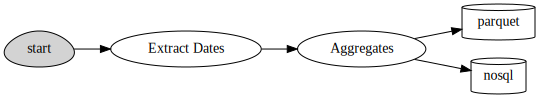

In [6]:
# Import storey so it will be available on our scope
# when testing the pipeline
import storey

# Define the Transactions FeatureSet
transaction_set = fs.FeatureSet("transactions", 
                                 entities=[fs.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

# Get FeatureSet computation graph
transaction_graph = transaction_set.graph

transaction_graph\
    .to(
        class_name='DateExtractor', 
        name='Extract Dates', 
        parts = ['hour', 'day_of_week'],
        timestamp_col = 'timestamp',
    )

windows = ['1h', '12h', '24h']
transaction_set.add_aggregation(name=f'amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=windows,
                                period='30m')

transaction_set.set_targets()

# User our loaded DF as the datasource and ingest it through
# the define pipeline
resp = fs.ingest(transaction_set, data, 
                 infer_options=fs.InferOptions.default())
transaction_set.plot(rankdir="LR", with_targets=True)

In [7]:
resp.head()

,amount_sum_1h,amount_sum_12h,amount_sum_24h,amount_max_1h,amount_max_12h,amount_max_24h,amount_count_1h,amount_count_12h,amount_count_24h,amount_avg_1h,...,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C886658445,63.48,63.48,63.48,63.48,63.48,63.48,1.0,1.0,1.0,63.48,...,28007,28007,es_wellnessandbeauty,63.48,0,2020-03-02 00:32:41.379426,M1946091778,06731466446f4de4b22efc42cd5cc86d,0,0
C15777324,39.08,39.08,39.08,39.08,39.08,39.08,1.0,1.0,1.0,39.08,...,28007,28007,es_transportation,39.08,0,2020-04-04 04:37:48.094624,M1823072687,4e9efd737f0545bda0b0ea2730493615,4,5
C1941625566,29.68,29.68,29.68,29.68,29.68,29.68,1.0,1.0,1.0,29.68,...,28007,28007,es_transportation,29.68,0,2020-01-01 12:17:14.234501,M348934600,52445dd1a7ff4c998715714cb61281ce,12,2
C251449240,22.16,22.16,22.16,22.16,22.16,22.16,1.0,1.0,1.0,22.16,...,28007,28007,es_transportation,22.16,0,2020-03-28 20:09:43.812029,M348934600,d7638b69a15c49788afbb8228ef6e725,20,5
C1960353164,0.59,0.59,0.59,0.59,0.59,0.59,1.0,1.0,1.0,0.59,...,28007,28007,es_transportation,0.59,0,2020-10-24 12:27:31.115236,M348934600,967d8f0816e543e1999d40245ded8f32,12,5


### Define the Events Set

In [9]:
events = pd.read_csv('data/events.csv', index_col=0, quotechar="\'", parse_dates=['timestamp'])
events.head()

,source,event,timestamp
0,C1974668487,details_change,2020-09-19 15:12:26.321576
1,C1973547259,login,2020-10-12 15:28:25.703053
2,C515668508,login,2020-09-16 10:10:50.498604
3,C1721541488,details_change,2020-10-02 13:59:25.553802
4,C394979408,password_change,2020-10-14 23:27:41.291391


In [10]:
from mlrun.feature_store.steps import OneHotEncoder

events_set = fs.FeatureSet("events",
                           entities=[fs.Entity("source")],
                           timestamp_key='timestamp', 
                           description="events feature set")
events_set_graph = events_set.spec.graph

events_mapping = {'event': list(events.event.unique())}

events_set_graph.\
    to(OneHotEncoder(mapping=events_mapping), name='encode_event_types')

events_set.set_targets()

events_df=fs.ingest(events_set, events)
events_df.head()

,event_details_change,event_login,event_password_change,timestamp
source,,,,
C1974668487,1,0,0,2020-09-19 15:12:26.321576
C1973547259,0,1,0,2020-10-12 15:28:25.703053
C515668508,0,1,0,2020-09-16 10:10:50.498604
C1721541488,1,0,0,2020-10-02 13:59:25.553802
C394979408,0,0,1,2020-10-14 23:27:41.291391


### Define the Parties Set

#### helper functions

#### Feature Set

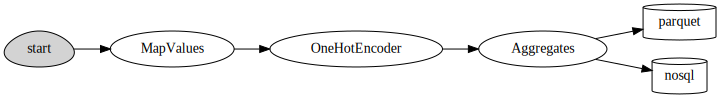

In [11]:
from mlrun.feature_store.steps import MapValues

parties_set = fs.FeatureSet("parties", entities=[fs.Entity("source")], description="involved parties dataset")
parties_set_graph = parties_set.spec.graph


main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(data.gender.unique())}

parties_set_graph\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))
    


for category in main_categories:
    parties_set.add_aggregation(name=category,column=f'category_{category}', operations=['count'], windows=['14d'], period='1d')

parties_set.set_targets()
parties_set.plot(rankdir="LR", with_targets=True)

In [12]:
parties_df=fs.ingest(parties_set, data)
parties_df.columns

Index(['es_transportation_count_14d', 'es_health_count_14d',
       'es_otherservices_count_14d', 'es_food_count_14d',
       'es_hotelservices_count_14d', 'es_barsandrestaurants_count_14d',
       'es_tech_count_14d', 'es_sportsandtoys_count_14d',
       'es_wellnessandbeauty_count_14d', 'es_hyper_count_14d',
       'es_fashion_count_14d', 'es_home_count_14d', 'es_contents_count_14d',
       'es_travel_count_14d', 'es_leisure_count_14d', 'age_mapped', 'step',
       'age', 'gender_F', 'gender_M', 'gender_U', 'gender_E', 'zipcodeOri',
       'zipMerchant', 'category_es_transportation', 'category_es_health',
       'category_es_otherservices', 'category_es_food',
       'category_es_hotelservices', 'category_es_barsandrestaurants',
       'category_es_tech', 'category_es_sportsandtoys',
       'category_es_wellnessandbeauty', 'category_es_hyper',
       'category_es_fashion', 'category_es_home', 'category_es_contents',
       'category_es_travel', 'category_es_leisure', 'amount', 'fraud

### Define the processing pipeline
- Transformation functions
- Sliding window aggregation
- Set targets (NoSQL and Parquet)

### Run ingestion task using MLRun & Storey

In order to ingest the dataframe to the featureset, use the `ingest` function.

### Create a labels dataset for model training

In [13]:
labels = data[['fraud','source','timestamp']].copy()

In [14]:
labels = labels.rename(columns={"fraud": "label"})

In [15]:
labels['label'] = labels['label'].astype(int)

In [16]:
labels_filepath = os.path.join(data_path, 'labels.parquet')
labels.to_parquet(labels_filepath)

In [17]:
labels_set = fs.FeatureSet("labels", entities=[fs.Entity("source")], timestamp_key='timestamp',
                           description="training labels")
labels_set.set_targets()
df = fs.infer(labels_set, labels_filepath)

In [18]:
df = fs.ingest(labels_set, labels_filepath)

In [19]:
data.describe()

,step,zipcodeOri,zipMerchant,amount,fraud
count,100000.000000,100000.0,100000.0,100000.000000,100000.000000
mean,77.710130,28007.0,28007.0,37.985358,0.012840
std,41.946828,0.0,0.0,107.076896,0.112584
min,0.000000,28007.0,28007.0,0.000000,0.000000
25%,42.000000,28007.0,28007.0,13.757500,0.000000
50%,80.000000,28007.0,28007.0,26.890000,0.000000
75%,114.000000,28007.0,28007.0,42.600000,0.000000
max,147.000000,28007.0,28007.0,6405.950000,1.000000
